In [2]:
using Pkg
Pkg.status()
using SymPy
using BenchmarkTools, LinearAlgebra, LazyArrays, BandedMatrices
using PyPlot

      Status `~/.julia/environments/v1.7/Project.toml`
  [aae01518] BandedMatrices v0.17.0
  [6e4b80f9] BenchmarkTools v1.3.1
  [8e7c35d0] BlockArrays v0.16.18
  [336ed68f] CSV v0.10.4
  [ce91de38] ColorBitstring v0.1.1
  [35d6a980] ColorSchemes v3.19.0
  [a93c6f00] DataFrames v1.3.4
  [28b8d3ca] GR v0.64.4
  [7073ff75] IJulia v1.23.3
  [b964fa9f] LaTeXStrings v1.3.0
  [5078a376] LazyArrays v0.22.10
  [a3b82374] MatrixFactorizations v0.9.1
  [91a5bcdd] Plots v1.29.0
  [f27b6e38] Polynomials v3.1.4
  [438e738f] PyCall v1.93.1
  [d330b81b] PyPlot v2.10.0
  [295af30f] Revise v3.3.3
  [f8ebbe35] SemiseparableMatrices v0.3.3
  [3cc68bcd] SetRounding v0.2.1
  [24249f21] SymPy v1.1.6
  [ade2ca70] Dates
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
  [8dfed614] Test


In [198]:

function invR(A)
    if size(A)[1] != size(A)[2]
        return A' * inv(A * A')
    else
        return inv(A)
    end
end
function invL(A)
    if size(A)[1] != size(A)[2]
        return inv(A' * A) * A'
    else
        return inv(A)
    end
end

function invBlockBiU(U, bw) # have problem
    n = size(U)[2]
    r = rem(n, bw)
    T = eltype(U)
    E_k = zeros(T, n, bw)
    E_k[n-bw+1:n, :] = one(U[n-bw+1:n, n-bw+1:n])
    # X = qr(U) \ E_k
    # if typeof(U) == BandedMatrix
        X = qr(U) \ E_k
    #     print(11111111111111111)
    # else
        # X = U \ E_k
    Yt = zeros(T, bw, n)
    for i in n : -bw : r+bw
        Di = U[i-bw+1:i, i-bw+1:i]
        Xi = X[i-bw+1:i, :]
        # if typeof(U) == BandedMatrix
            Yti = qr(Di * Xi) \ I
        # else
            # Yti = inv(Di * Xi)
            
        # Yti = qr(Di * Xi) \ I
        # Yti = inv(Di * Xi)
        Yt[:, i-bw+1:i] = Yti
    end
    D0 = U[1:r, 1:r]
    # D0inv = qr(D0) \ I
    X0 = X[1:r, :]
    Yt0 = invR(D0 * X0)
    Yt[:, 1:r] = Yt0
    Uinv = triu(X * Yt)
    Uinv
end


invBlockBiU (generic function with 1 method)

In [206]:
include("genTestMat.jl")

n = 1000
bw = 2
U = generateTestTriangular(n, bw, BandedMatrix, BigFloat)

# U = generateTestTriangular(n, bw, UpperTriangular, BigFloat)
# U = generateTestTriangular(n, bw, Matrix, BigFloat)
# U = generateTestTriangular(n, bw, Bidiagonal, BigFloat)
# Bidiagonal
# display(U)
display(typeof(U))
# U = generateTestTriangular(n, bw, Bidiagonal, Float64)
# U = generateTestTriangular(n, bw, BandedMatrix, Float64)


Uinv = invBlockBiU(U, bw)
II = U * Uinv
# display(II)
display(II ≈ I)
norm(II - I)

# invBidiagU(U)

BandedMatrix{BigFloat, Matrix{BigFloat}, Base.OneTo{Int64}}

false

6.52160475290256761666715646758864085342787655731736573052000100001317459915963e-15

In [197]:
x = rand(n)

b = U * x

x1 = Uinv * b
norm(x - x1)


II[1:10, 1:10]

10×10 Matrix{BigFloat}:
 1.0  4.17612e-06  -8.10128e-07  0.0          …   0.0          0.0
 0.0  1.00492      -0.00140571   7.35062e-06      0.0          0.0
 0.0  0.0           1.00032      3.95996e-06      0.0          0.0
 0.0  0.0           0.0          1.00002          0.0          0.0
 0.0  0.0           0.0          0.0              3.00249e-07  0.0
 0.0  0.0           0.0          0.0          …  -1.45409e-07  0.0
 0.0  0.0           0.0          0.0              1.76355e-06  0.0
 0.0  0.0           0.0          0.0             -0.00219096   6.44986e-06
 0.0  0.0           0.0          0.0              0.998953     1.43187e-06
 0.0  0.0           0.0          0.0              0.0          1.0

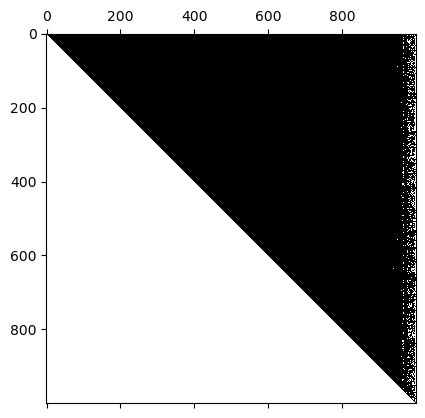

PyObject <matplotlib.image.AxesImage object at 0x3b3a6ca30>

In [190]:
spy(II)

In [191]:
map!(x -> isapprox(x, 0, atol=1e-8) ? 0 : x, II, II)

1000×1000 Matrix{BigFloat}:
 1.0  4.17612e-06  -8.10128e-07  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.00492      -0.00140571      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           1.00032         0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0          …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0          …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0           0.0             0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                               ⋱            ⋮               

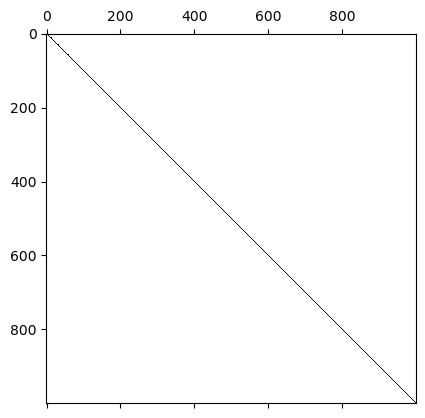

PyObject <matplotlib.image.AxesImage object at 0x3af001c10>

In [192]:
spy(II)

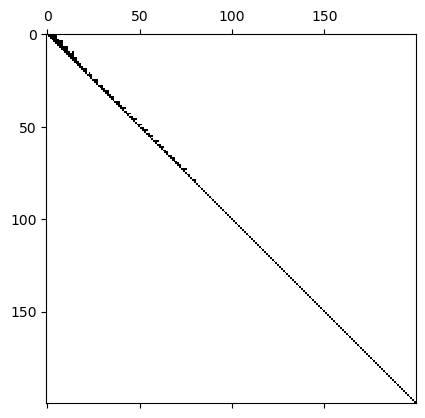

PyObject <matplotlib.image.AxesImage object at 0x3b037e670>

In [193]:
spy(II[1:200, 1:200])